In [1]:
import numpy as np
import networkx as nx
import scipy.sparse as spsp
import scipy as sp
from scipy.sparse import diags
from scipy.sparse.linalg import LinearOperator
import pickle

from sklearn.metrics import precision_recall_curve, auc

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from sklearn.decomposition import NMF

# Networks

In [2]:
with open('networks.pkl', 'rb') as f:
    networks, networks_names = pickle.load(f)

len(networks_names), len(networks_names)

(6, 6)

# Metrics

In [3]:
def precision(A_train, A_probe, A_pred):
    non_observed = (A_train.A == 0)
    non_observed_true = (A_probe.A[non_observed] != 0).astype('int')
    non_observed_pred = A_pred[non_observed]
    
    order = non_observed_pred.argsort()[::-1]
    
    L = (A_probe != 0).sum() // 2
    
    return non_observed_true[order][:L].mean()

def recall(A_train, A_probe, A_pred):
    non_observed = (A_train.A == 0)
    non_observed_true = (A_probe.A[non_observed] > 0).astype('int')
    non_observed_pred = A_pred[non_observed]
    
    order = non_observed_pred.argsort()[::-1]
    
    L = (A_probe != 0).sum() // 2

    return non_observed_true[order][: L].sum() / non_observed_true.sum()

def F_score(precision, recall):
    return 2 * precision * recall / (precision + recall)
    
def pr_curve(A_train, A_probe, A_pred):
    non_observed = (A_train.A == 0)
    non_observed_true = (A_probe.A[non_observed] > 0).astype('int')
    non_observed_pred = A_pred[non_observed]
    
    precision, recall, _ = precision_recall_curve(non_observed_true, non_observed_pred)

    return recall, precision 

def AUC(A_train, A_probe, A_pred, n = 100):
    A_shape = A_train.shape[0]
    nonzero_idx = A_probe.nonzero()
    nonzero_idx = nonzero_idx[0] * A_shape + nonzero_idx[1]
    nonzero_full_idx = (A_train + A_probe).nonzero()
    nonzero_full_idx = nonzero_full_idx[0] * A_shape + nonzero_full_idx[1]
    zero_idx = np.setdiff1d(np.arange(A_shape**2), nonzero_full_idx)
    
    np.random.seed(0) 
    ex_links_idx = np.random.choice(nonzero_idx, n)
    np.random.seed(0) 
    nonex_links_idx = np.random.choice(zero_idx, n)
    
    exist_elms_weights = A_pred[ex_links_idx//A_shape, ex_links_idx%A_shape]
    nonexist_elms_weights = A_pred[nonex_links_idx//A_shape, nonex_links_idx%A_shape]
    
    n1 = np.sum(exist_elms_weights > nonexist_elms_weights)
    n2 = n - n1
    
    return (n1 + 0.5 * n2) / n

# Train test split

In [4]:
def train_test_split(a, test_size):
    nnz_row_inds, nnz_col_inds = a.nonzero()
    nnz_num = nnz_row_inds.shape[0]
    
    test_nnz_num = int(test_size * nnz_num)
    np.random.seed(0)
    test_nnz_inds = np.random.choice(np.arange(nnz_num), test_nnz_num, False)
    
    test_nnz_row_inds, test_nnz_col_inds = nnz_row_inds[test_nnz_inds], nnz_col_inds[test_nnz_inds]
    
    
    e_test = spsp.csr_matrix((a[test_nnz_row_inds, test_nnz_col_inds].A[0],
                              (test_nnz_row_inds, test_nnz_col_inds)), shape=a.shape)
    e_train = a - e_test
    
    return e_train, e_test

# Pagerank

In [5]:
def pagerank_matrix(A):
    """
    INPUT: A - sp.sparse.csr_matrix (adjacency matrix)
    OUTPUT: G - sp.sparse.csr_matrix (pagerank matrix)
    """
    # we assume that G has a 'standart' format (g_{i,j} = 1 iff there is an edge from i to j)
    # but in GoogleMatrix (PageRankMatrix) definition it is the opposite
    #     (g_{i,j} = 1 iff there is an edge from j to i)
    A = A.T
    d = A.sum(axis=0).A1
    # it is also stated that if vertex doesn't have incoming connections
    # we should fill the corresponding column with 1/n, but this way we will ruine the sparcity
    # so I decided do nothing with zeros
    # in order not to encounter division by zero we replace zeros on diagonal with ones
    d[d == 0] = 1
    # we do the normalization as the multiplication with the diagonal matrix in order to handle zero columns
    return A @ sp.sparse.diags(1 / d)

def power_method(A, x0, max_iter, eps):
    """
    INPUT: A - sp.sparse.csr_matrix (some matrix),
           x0 - np.ndarray (1D) (initial guess),
           max_iter - integer (maximum number of iterations),
           eps - float (neaded absolute accuracy (||Ax - lambda*x||_2))
    OUTPUT: x - np.ndarray (1D) (eigenvector),
            l - float (eigenvalue),
            res - np.darray (1D) (residuals at each iteration)
    """
    
    x = x0.copy()
    res = []
    
    for _ in range(max_iter):
        new_x = A @ x
        l = np.dot(new_x, x)
        r = np.linalg.norm(new_x - l * x, ord=2)
        res.append(r)

        x = new_x
        x = x / np.linalg.norm(x, ord=2)
        
        if r < eps:
            break
        
    l = np.dot((A @ x), x)
    res.append(np.linalg.norm(A @ x - l * x, ord=2))
        
    return x, l, np.array(res)

def pagerank_matvec(A, d, x):
    """
    INPUT:  A - np.ndarray (2D),
            d - float (from 0.0 to 1.0),
            x - np.ndarray (1D, size of A.shape[0/1])
    OUTPUT: y - np.ndarray (1D, size of x)
    """
    return (d * (A @ x)) + (((1 - d) / A.shape[0] * x.sum()) * np.ones_like(x))

def pagerank(A, d=0.85, max_iter=int(1e4), eps=1e-9):
    """
    INPUT:  A - np.ndarray (2D),
            d - float (from 0.0 to 1.0),
            max_iter - integer (maximum number of iterations),
            eps - float (neaded absolute accuracy (||Ax - lambda*x||_2))
    OUTPUT: eigenvec - np.ndarray (1D) (eigenvector),
            eigenval - float (eigenvalue),
            residuals - np.darray (1D) (residuals at each iteration)
    """
    pagerank_m = pagerank_matrix(A)
    
    
    L = LinearOperator(pagerank_m.shape,
                       matvec=lambda x, pagerank_m=pagerank_m, d=d: pagerank_matvec(pagerank_m, d, x))
    
    eigenvec, eigenval, residuals = power_method(L, np.ones(pagerank_m.shape[0]), max_iter, eps)
    
    return eigenvec, eigenval, residuals

# Asymmetric link clustering coefficient score

In [6]:
def get_Sm(A):
    S_m_z = A.T.multiply(((A @ A).T) @ sp.sparse.diags(1 / np.maximum((A.sum(axis=1) - 1).A, 1).reshape((-1))))

    G = ((A + A.T) > 0).astype('int')
    S_m = G.multiply(S_m_z) @ G
    
    return (S_m).maximum(S_m.T)

# Update rules

# Original formulas (dense form (convert everything to dense matrices))

In [7]:
def update_u_original_dense(a, u, v, w, y, c, beta, gamma):

    num = (y * a) @ v + gamma * c @ u @ w.T
    den = (y * (u @ v.T)) @ v + gamma * u @ w @ u.T @ u @ w.T + beta * u
    
    den[np.abs(den) < 1e-15] = 1
    return (u * num) / den

def update_v_original_dense(a, u, v, w, y, c, beta, gamma):

    num = (y * a).T @ u
    den = (y * (u @ v.T)).T @ u + beta * v
    
    den[np.abs(den) < 1e-15] = 1
    return (v * num) / den

def update_w_original_dense(a, u, v, w, y, c, beta, gamma):

    num = u.T @ c @ u
    den = u.T @ u @ w @ u.T @ u
    
    den[np.abs(den) < 1e-15] = 1
    return (w * num) / den

## Updated formulas  (dense form)

In [8]:
def update_u_new_dense(a, u, v, w, y, c, beta, gamma):

    num = (y * a * y) @ v + gamma * c @ u @ w.T + gamma * c.T @ u @ w
    den = (y * (u @ v.T) * y) @ v + gamma * u @ w @ u.T @ u @ w.T \
          + gamma * u @ w.T @ u.T @ u @ w + beta * u
    
    den[np.abs(den) < 1e-15] = 1
    return (u * num) / den

def update_v_new_dense(a, u, v, w, y, c, beta, gamma):

    num = ((y * a).T * y.T) @ u
    den = ((y * (u @ v.T)).T * y.T) @ u + beta * v
    
    den[np.abs(den) < 1e-15] = 1
    return (v * num) / den

def update_w_new_dense(a, u, v, w, y, c, beta, gamma):

    num = u.T @ c @ u
    den = u.T @ u @ w @ u.T @ u
    
    den[np.abs(den) < 1e-15] = 1
    return (w * num) / den

## Sparse form

In [9]:
def update_u_new_sparse(a, u, v, w, s, c, c_t, s_dot_a, s_dot_s_dot_a, s_dot_s, alpha, beta, gamma):
    u_t_dot_u = u.T @ u
    u_dot_v_t = u @ v.T
    
    num = (a + 2 * alpha * s_dot_a + alpha ** 2 * s_dot_s_dot_a) @ v \
            + gamma * (c @ (u @ w.T) + c_t @ (u @ w))
    
    den = gamma * (u @ (w @ u_t_dot_u @ w.T) \
              + u @ (w.T @ u_t_dot_u @ w)) + beta * u \
              + u @ (v.T @ v) + 2 * alpha * s.multiply(u_dot_v_t) @ v \
              + alpha ** 2 * (s_dot_s.multiply(u_dot_v_t)) @ v
    
    den[np.abs(den) < 1e-15] = 1
    
    return (u * num) / den

def update_v_new_sparse(a_t, u, v, s_t, a_hadam_prod_s_t, a_hadam_prod_s_t_dot_s_t, s_t_dot_s_t, alpha, beta):
    v_dot_u_t_dot_u = v @ (u.T @ u)
    v_dot_u_t = v @ u.T
    
    num = (a_t + 2 * alpha * a_hadam_prod_s_t + alpha ** 2 * a_hadam_prod_s_t_dot_s_t) @ u
    den = v_dot_u_t_dot_u + beta * v \
            + (2 * alpha * s_t.multiply(v_dot_u_t)) @ u \
            + (alpha ** 2 * s_t_dot_s_t).multiply(v_dot_u_t) @ u
    
    den[np.abs(den) < 1e-15] = 1
    
    return (v * num) / den

def update_w_new_sparse(u, w, c):
    num = u.T @ c @ u
    
    u_t_dot_u = u.T @ u
    den = u_t_dot_u @ w @ u_t_dot_u
    
    den[np.abs(den) < 1e-15] = 1
    
    return (w * num) / den

# Main algorithm

In [10]:
def NMF_AP_sparse(a, k, n_iter, alpha, beta, gamma, eps):
    
    n = a.shape[0]
    
    np.random.seed(0)
    u = np.random.rand(n, k)
    np.random.seed(0) 
    v = np.random.rand(n, k)
    np.random.seed(0) 
    w = np.random.rand(k, k)
    
    c = pagerank(a)[0]
    a = (a!=0).astype(int)
    c = spsp.csr_matrix(a.multiply(c.reshape(-1, 1)))
    
    sm = get_Sm(a)
    s = sm + a
    
    s_dot_a = s.multiply(a)
    s_t = s.T
    a_t = a.T
    a_hadam_prod_s_t = a_t.multiply(s_t)
    a_hadam_prod_s_t_dot_s_t = a_hadam_prod_s_t.multiply(s_t)
    s_t_dot_s_t = s_t.multiply(s_t)
    s_dot_s_dot_a = s.multiply(s_dot_a)
    s_dot_s = s.multiply(s)
    c_t = c.T
    
    for i in range(n_iter):
        
        u_prev, v_prev = u.copy(), v.copy()
        
        new_u = update_u_new_sparse(a, u, v, w, s, c, c_t, s_dot_a, s_dot_s_dot_a, s_dot_s, alpha, beta, gamma)
        new_v = update_v_new_sparse(a_t, u, v, s_t, a_hadam_prod_s_t, a_hadam_prod_s_t_dot_s_t, s_t_dot_s_t, alpha, beta)
        new_w = update_w_new_sparse(u, w, c)
        
        u, v, w = new_u, new_v, new_w
        
        norm = np.linalg.norm(a - u @ v.T, 'fro')
        
        if norm < eps:
            break

    return u, v.T


def NMF_AP_dense(a, k, n_iter, alpha, beta, gamma, eps, new_update_formulas):
    
    n = a.shape[0]
    
    np.random.seed(0)
    u = np.random.rand(n, k)
    np.random.seed(0) 
    v = np.random.rand(n, k)
    np.random.seed(0) 
    w = np.random.rand(k, k)
    
    c = pagerank(a)[0]
    a = (a!=0).astype(int)
    c = a.multiply(c.reshape(-1, 1)).todense().A
    
    sm = get_Sm(a).todense().A
    a = a.todense().A
    y = 1 + alpha * (sm + a)
    
    
    for i in range(n_iter):
        if new_update_formulas:
            new_u = update_u_new_dense(a, u, v, w, y, c, beta, gamma)
            new_v = update_v_new_dense(a, u, v, w, y, c, beta, gamma)
            new_w = update_w_new_dense(a, u, v, w, y, c, beta, gamma)
        else:
            new_u = update_u_original_dense(a, u, v, w, y, c, beta, gamma)
            new_v = update_v_original_dense(a, u, v, w, y, c, beta, gamma)
            new_w = update_w_original_dense(a, u, v, w, y, c, beta, gamma)
        
        u, v, w = new_u, new_v, new_w
        
        norm = np.linalg.norm(a - u @ v.T, 'fro')
        
        if np.linalg.norm(a - u @ v.T, 'fro') < eps:
            break

    return u, v.T

# Comparison

## Computation time

In [11]:
k = 40
n_iter = 39
alpha, beta, gamma = 4, 0.005, 0.1
eps = 1e-9

times = []

for network, network_name in zip(networks, networks_names):
    i = 0
    
    print((network_name, i), end='\r')
    
    network_times = {}
    time = %timeit -oqr 1 NMF_AP_dense(network, k, n_iter, alpha, beta, gamma, eps, new_update_formulas=False)
    network_times['Original formulas'] = time.average
        
    i = 1
    
    print((network_name, i), end='\r')
    
    time = %timeit -oqr 1 NMF_AP_dense(network, k, n_iter, alpha, beta, gamma, eps, new_update_formulas=True)
    network_times['New formulas (dense)'] = time.average
        
    i = 2
    
    print((network_name, i), end='\r')

    time = %timeit -oqr 1 NMF_AP_sparse(network, k, n_iter, alpha, beta, gamma, eps)
    network_times['New formulas (sparse)'] = time.average
        
    times.append(network_times)

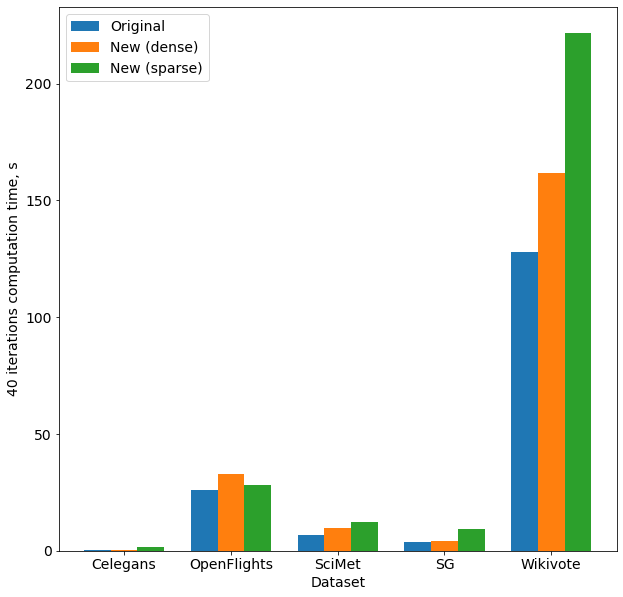

In [12]:
plt.figure(figsize=(10,10))
centers = np.arange(1, len(times)+1)
d = (centers[1] - centers[0])

original_times = [i['Original formulas'] for i in times]
new_dense_times = [i['New formulas (dense)'] for i in times]
new_sparse_times = [i['New formulas (sparse)'] for i in times]

plt.bar(centers-d/4, original_times, d/4, label='Original')
plt.bar(centers, new_dense_times, d/4, label='New (dense)')
plt.bar(centers+d/4, new_sparse_times, d/4, label='New (sparse)')
    
plt.xlabel('Dataset')
plt.ylabel('40 iterations computation time, s')
plt.xticks(centers, labels=networks_names[:-1])
plt.legend()

plt.savefig('Time.png')

## Metrics

In [13]:
k = 40
n_iter = 39
alpha, beta, gamma = 4, 0.005, 0.1
eps = 1e-9
test_size=0.3

precision_scores = []
recall_scores = []
roc_auc_scores = []
f_scores = []
aupr_scores = []


for network, network_name in zip(networks, networks_names):
    e_train, e_test = train_test_split(network, test_size)
    
    i = 0
    
    print((network_name, i), end='\r')
    
    network_precision_scores = {}
    network_recall_scores = {}
    network_roc_auc_scores = {}
    network_f_scores = {}
    network_aupr_scores = {}
    
    u, v_t = NMF_AP_dense(e_train, k, n_iter, alpha, beta, gamma, eps, new_update_formulas=False)
    e_pred = u @ v_t
    
    pr = precision(e_train, e_test, e_pred)
    r = recall(e_train, e_test, e_pred)
    roc_auc = AUC(e_train, e_test, e_pred, 100)
    f = F_score(pr, r)
    aupr = auc(*pr_curve(e_train, e_test, e_pred))
    
    network_precision_scores['Original formulas'] = pr
    network_recall_scores['Original formulas'] = r
    network_roc_auc_scores['Original formulas'] = roc_auc
    network_f_scores['Original formulas'] = f
    network_aupr_scores['Original formulas'] = aupr    
        
    i = 1
    
    print((network_name, i), end='\r')
    
    u, v_t = NMF_AP_dense(e_train, k, n_iter, alpha, beta, gamma, eps, new_update_formulas=True)
    e_pred = u @ v_t
    
    pr = precision(e_train, e_test, e_pred)
    r = recall(e_train, e_test, e_pred)
    roc_auc = AUC(e_train, e_test, e_pred, 100)
    f = F_score(pr, r)
    aupr = auc(*pr_curve(e_train, e_test, e_pred))
    
    network_precision_scores['New formulas (dense)'] = pr
    network_recall_scores['New formulas (dense)'] = r
    network_roc_auc_scores['New formulas (dense)'] = roc_auc
    network_f_scores['New formulas (dense)'] = f
    network_aupr_scores['New formulas (dense)'] = aupr   
        
    i = 2
    
    print((network_name, i), end='\r')

    u, v_t = NMF_AP_sparse(e_train, k, n_iter, alpha, beta, gamma, eps)
    e_pred = u @ v_t
    
    pr = precision(e_train, e_test, e_pred)
    r = recall(e_train, e_test, e_pred)
    roc_auc = AUC(e_train, e_test, e_pred, 100)
    f = F_score(pr, r)
    aupr = auc(*pr_curve(e_train, e_test, e_pred))
    
    network_precision_scores['New formulas (sparse)'] = pr
    network_recall_scores['New formulas (sparse)'] = r
    network_roc_auc_scores['New formulas (sparse)'] = roc_auc
    network_f_scores['New formulas (sparse)'] = f
    network_aupr_scores['New formulas (sparse)'] = aupr 
        
    precision_scores.append(network_precision_scores)
    recall_scores.append(network_recall_scores)
    roc_auc_scores.append(network_roc_auc_scores)
    f_scores.append(network_f_scores)
    aupr_scores.append(network_aupr_scores)

In [14]:
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        plt.gca().annotate('%.2f'%height,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=45)

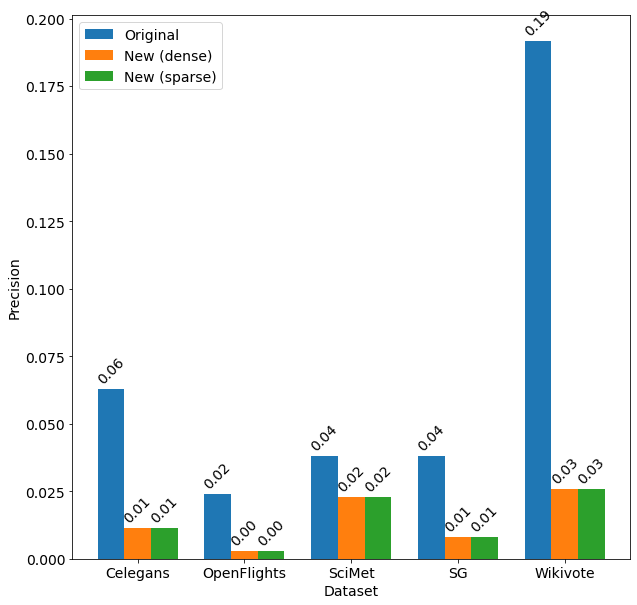

In [15]:
plt.figure(figsize=(10,10))
centers = np.arange(1, len(precision_scores)+1)
d = (centers[1] - centers[0])

original_scores = [i['Original formulas'] for i in precision_scores]
new_dense_scores = [i['New formulas (dense)'] for i in precision_scores]
new_sparse_scores = [i['New formulas (sparse)'] for i in precision_scores]

b1 = plt.bar(centers-d/4, original_scores, d/4, label='Original')
b2 = plt.bar(centers, new_dense_scores, d/4, label='New (dense)')
b3 = plt.bar(centers+d/4, new_sparse_scores, d/4, label='New (sparse)')
    
plt.xlabel('Dataset')
plt.ylabel('Precision')
plt.xticks(centers, labels=networks_names[:-1])
plt.legend()

autolabel(b1)
autolabel(b2)
autolabel(b3)

plt.savefig('Precision_10.png')

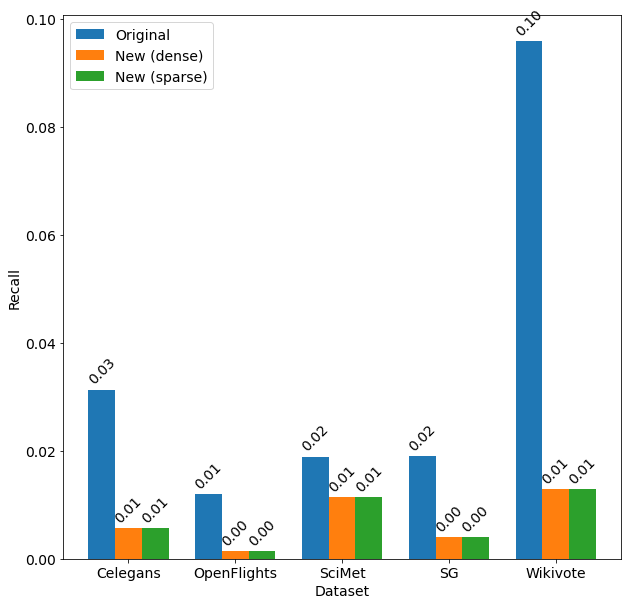

In [16]:
plt.figure(figsize=(10,10))
centers = np.arange(1, len(recall_scores)+1)
d = (centers[1] - centers[0])

original_scores = [i['Original formulas'] for i in recall_scores]
new_dense_scores = [i['New formulas (dense)'] for i in recall_scores]
new_sparse_scores = [i['New formulas (sparse)'] for i in recall_scores]

b1 = plt.bar(centers-d/4, original_scores, d/4, label='Original')
b2 = plt.bar(centers, new_dense_scores, d/4, label='New (dense)')
b3 = plt.bar(centers+d/4, new_sparse_scores, d/4, label='New (sparse)')
    
plt.xlabel('Dataset')
plt.ylabel('Recall')
plt.xticks(centers, labels=networks_names[:-1])
plt.legend()

autolabel(b1)
autolabel(b2)
autolabel(b3)

plt.savefig('Recall_10.png')

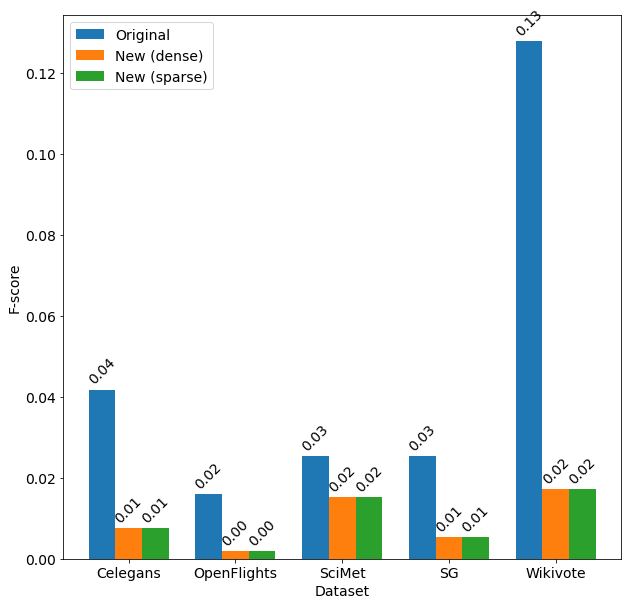

In [17]:
plt.figure(figsize=(10,10))
centers = np.arange(1, len(f_scores)+1)
d = (centers[1] - centers[0])

original_scores = [i['Original formulas'] for i in f_scores]
new_dense_scores = [i['New formulas (dense)'] for i in f_scores]
new_sparse_scores = [i['New formulas (sparse)'] for i in f_scores]

b1 = plt.bar(centers-d/4, original_scores, d/4, label='Original')
b2 = plt.bar(centers, new_dense_scores, d/4, label='New (dense)')
b3 = plt.bar(centers+d/4, new_sparse_scores, d/4, label='New (sparse)')
    
plt.xlabel('Dataset')
plt.ylabel('F-score')
plt.xticks(centers, labels=networks_names[:-1])
plt.legend()

autolabel(b1)
autolabel(b2)
autolabel(b3)

plt.savefig('F_scores_10.png')

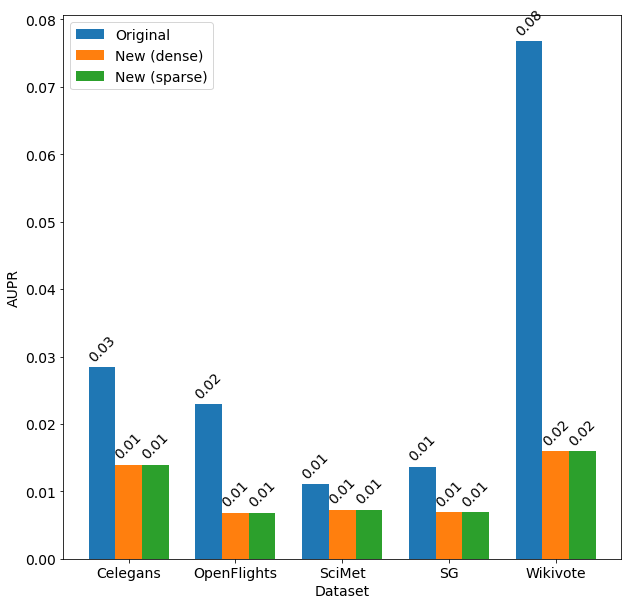

In [18]:
plt.figure(figsize=(10,10))
centers = np.arange(1, len(aupr_scores)+1)
d = (centers[1] - centers[0])

original_scores = [i['Original formulas'] for i in aupr_scores]
new_dense_scores = [i['New formulas (dense)'] for i in aupr_scores]
new_sparse_scores = [i['New formulas (sparse)'] for i in aupr_scores]

b1 = plt.bar(centers-d/4, original_scores, d/4, label='Original')
b2 = plt.bar(centers, new_dense_scores, d/4, label='New (dense)')
b3 = plt.bar(centers+d/4, new_sparse_scores, d/4, label='New (sparse)')
    
plt.xlabel('Dataset')
plt.ylabel('AUPR')
plt.xticks(centers, labels=networks_names[:-1])
plt.legend()

autolabel(b1)
autolabel(b2)
autolabel(b3)

plt.savefig('AUPR_10.png')

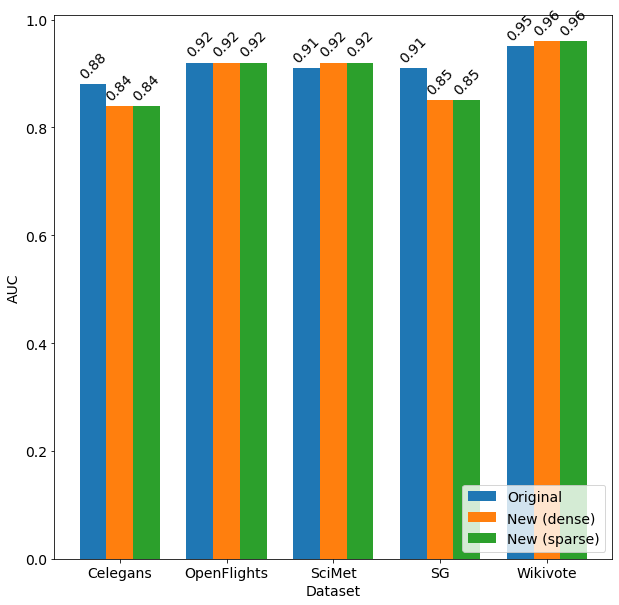

In [19]:
plt.figure(figsize=(10,10))
centers = np.arange(1, len(roc_auc_scores)+1)
d = (centers[1] - centers[0])

original_scores = [i['Original formulas'] for i in roc_auc_scores]
new_dense_scores = [i['New formulas (dense)'] for i in roc_auc_scores]
new_sparse_scores = [i['New formulas (sparse)'] for i in roc_auc_scores]

b1 = plt.bar(centers-d/4, original_scores, d/4, label='Original')
b2 = plt.bar(centers, new_dense_scores, d/4, label='New (dense)')
b3 = plt.bar(centers+d/4, new_sparse_scores, d/4, label='New (sparse)')
    
plt.xlabel('Dataset')
plt.ylabel('AUC')
plt.xticks(centers, labels=networks_names[:-1])
plt.legend(loc='lower right')

autolabel(b1)
autolabel(b2)
autolabel(b3)

plt.savefig('AUC_10.png')

# Dependency on ratio of missing links

In [20]:
k = 40
n_iter = 39
alpha, beta, gamma = 4, 0.005, 0.1
eps = 1e-9

AUC_values = {}
AUPR_values = {}

for network, network_name in zip(networks, networks_names):
    AUC_net_values = {'SVD':[], 'NMF':[], 'NMF-AP_old':[], 'NMF-AP_new':[]}
    AUPR_net_values = {'SVD':[], 'NMF':[], 'NMF-AP_old':[], 'NMF-AP_new':[]}
    for test_size in np.arange(0.1, 1, 0.1):        
        e_train, e_test = train_test_split(network, test_size)
        
        nmf = NMF(n_components=k, init='random', random_state=0)
        
        W = nmf.fit_transform(e_train)
        H = nmf.components_
        res_nmf = W @ H
        
        u, s, vt = sp.sparse.linalg.svds(e_train.astype('float64'), k)
        res_svd = u * s @ vt
        
        u, v_t = NMF_AP_dense(e_train, k, n_iter, alpha, beta, gamma, eps, new_update_formulas=False)
        res_nmf_ap_old = u @ v_t
        
        u, v_t = NMF_AP_dense(e_train, k, n_iter, alpha, beta, gamma, eps, new_update_formulas=True)
        res_nmf_ap_new = u @ v_t
        
        AUC_net_values['SVD'].append(AUC(e_train, e_test, res_svd, 100))
        AUC_net_values['NMF'].append(AUC(e_train, e_test, res_nmf, 100))
        AUC_net_values['NMF-AP_old'].append(AUC(e_train, e_test, res_nmf_ap_old, 100))
        AUC_net_values['NMF-AP_new'].append(AUC(e_train, e_test, res_nmf_ap_new, 100))
        
        AUPR_net_values['SVD'].append(auc(*pr_curve(e_train, e_test, res_svd)))
        AUPR_net_values['NMF'].append(auc(*pr_curve(e_train, e_test, res_nmf)))
        AUPR_net_values['NMF-AP_old'].append(auc(*pr_curve(e_train, e_test, res_nmf_ap_old)))
        AUPR_net_values['NMF-AP_new'].append(auc(*pr_curve(e_train, e_test, res_nmf_ap_new)))
        
    AUC_values[network_name] = AUC_net_values
    AUPR_values[network_name] = AUPR_net_values   
    
    fig = plt.figure()
    methods = AUC_values[network_name]
    
    for method in methods:
        plt.plot(np.arange(0.1, 1, 0.1), AUC_values[network_name][method], label=method, marker='*')
        
    plt.legend()
    plt.ylabel('AUC')
    plt.xlabel('Ratio of missing links')
    plt.title(network_name)
    plt.tight_layout()
    plt.savefig(network_name + '_AUC.png')
    fig.clf()
    plt.close(fig)
    
    fig = plt.figure()
    methods = AUPR_values[network_name]
    
    for method in methods:
        plt.plot(np.arange(0.1, 1, 0.1), AUPR_values[network_name][method], label=method, marker='*')
        
    plt.legend()
    plt.ylabel('AUPR')
    plt.xlabel('Ratio of missing links')
    plt.title(network_name)
    plt.tight_layout()
    plt.savefig(network_name + '_AUPR.png')
    fig.clf()
    plt.close(fig)

/home/glebzok/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/glebzok/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/glebzok/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/home/glebzok/.local/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations 

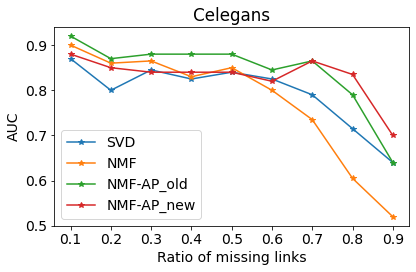

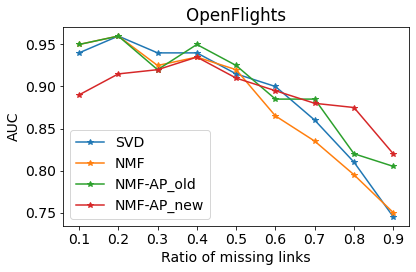

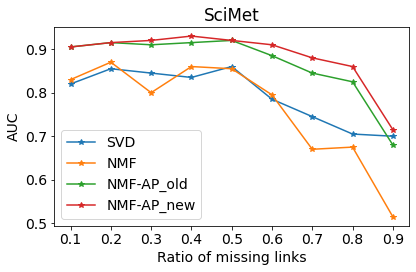

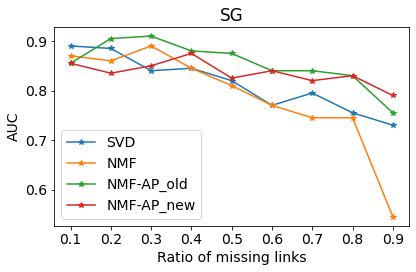

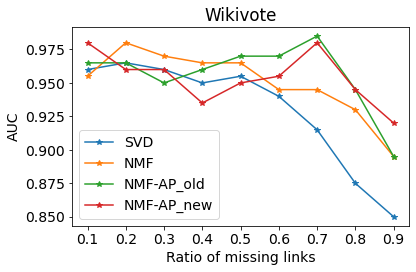

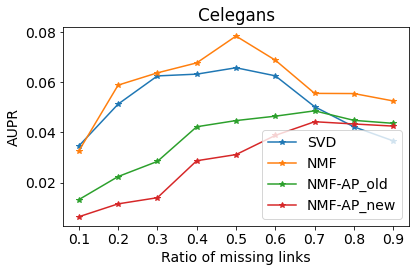

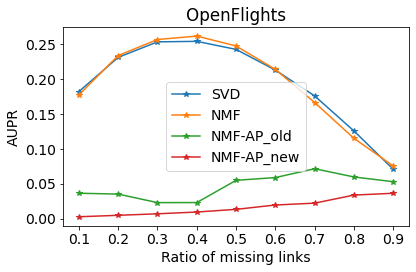

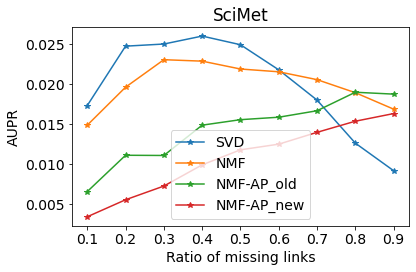

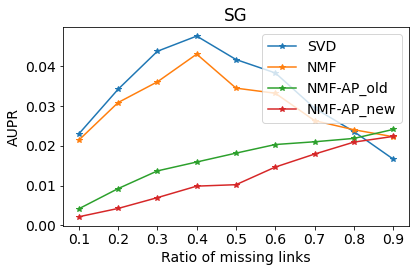

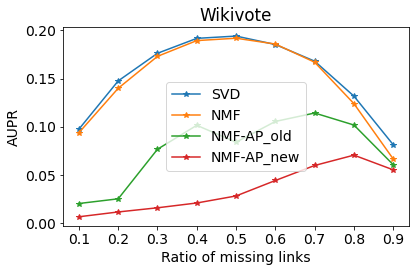

In [21]:
for net in AUC_values:
    plt.figure()
    methods = AUC_values[net]
    for method in methods:
        plt.plot(np.arange(0.1, 1, 0.1), AUC_values[net][method], label=method, marker='*')
    plt.legend()
    plt.ylabel('AUC')
    plt.xlabel('Ratio of missing links')
    plt.xticks(np.arange(0.1, 1, 0.1))
    plt.title(net)
    plt.tight_layout()
    plt.savefig(net + '_AUC.png')
    
for net in AUPR_values:
    plt.figure()
    methods = AUPR_values[net]
    for method in methods:
        plt.plot(np.arange(0.1, 1, 0.1), AUPR_values[net][method], label=method, marker='*')
    plt.legend()
    plt.ylabel('AUPR')
    plt.xlabel('Ratio of missing links')
    plt.xticks(np.arange(0.1, 1, 0.1))
    plt.title(net)
    plt.tight_layout()
    plt.savefig(net + '_AUPR.png')

# Dependency on size of latent space

In [22]:
n_iter = 39
alpha, beta, gamma = 4, 0.005, 0.1
test_size = 0.3
eps = 1e-9

AUC_values_old = {}
AUPR_values_old = {}
Precision_values_old = {}
F_score_values_old = {}

AUC_values_new = {}
AUPR_values_new = {}
Precision_values_new = {}
F_score_values_new = {}

for network, network_name in zip(networks, networks_names):
    
    print(network_name, end='\r')
    
    AUC_net_values_old = []
    AUPR_net_values_old = []
    Precision_net_values_old = []
    F_score_net_values_old = []
    
    AUC_net_values_new = []
    AUPR_net_values_new = []
    Precision_net_values_new = []
    F_score_net_values_new = []
    
    for k in np.arange(10, 110, 10):        
        e_train, e_test = train_test_split(network, test_size)
        
        u, v_t = NMF_AP_dense(e_train, k, n_iter, alpha, beta, gamma, eps, new_update_formulas=False)
        res_nmf_ap_old = u @ v_t
        
        AUC_net_values_old.append(AUC(e_train, e_test, res_nmf_ap_old))
        AUPR_net_values_old.append(auc(*pr_curve(e_train, e_test, res_nmf_ap_old)))
        pr, r = precision(e_train, e_test, res_nmf_ap_old), recall(e_train, e_test, res_nmf_ap_old)
        Precision_net_values_old.append(pr)
        F_score_net_values_old.append(F_score(pr, r))
        
        u, v_t = NMF_AP_dense(e_train, k, n_iter, alpha, beta, gamma, eps, new_update_formulas=True)
        res_nmf_ap_new = u @ v_t
  
        AUC_net_values_new.append(AUC(e_train, e_test, res_nmf_ap_new))
        AUPR_net_values_new.append(auc(*pr_curve(e_train, e_test, res_nmf_ap_new)))
        pr, r = precision(e_train, e_test, res_nmf_ap_new), recall(e_train, e_test, res_nmf_ap_new)
        Precision_net_values_new.append(pr)
        F_score_net_values_new.append(F_score(pr, r))
    
    AUC_values_old[network_name] = AUC_net_values_old
    AUPR_values_old[network_name] = AUPR_net_values_old
    Precision_values_old[network_name] = Precision_net_values_old
    F_score_values_old[network_name] = F_score_net_values_old
    
    AUC_values_new[network_name] = AUC_net_values_new
    AUPR_values_new[network_name] = AUPR_net_values_new
    Precision_values_new[network_name] = Precision_net_values_new
    F_score_values_new[network_name] = F_score_net_values_new

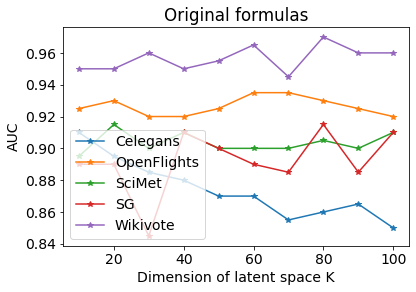

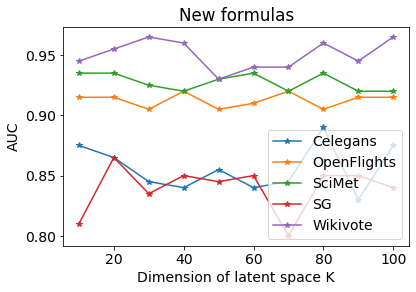

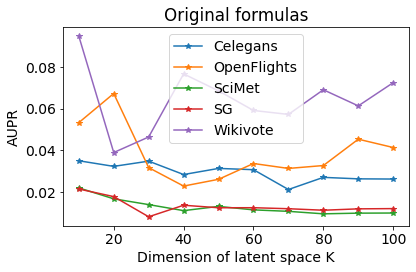

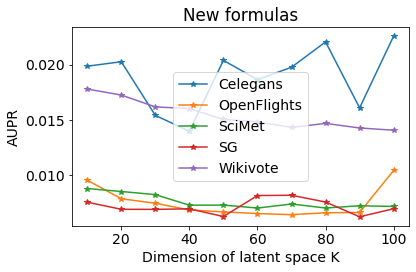

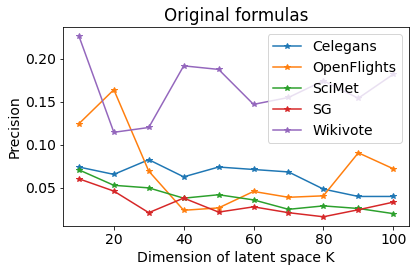

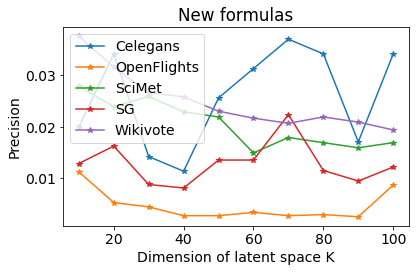

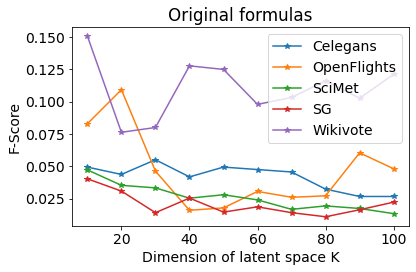

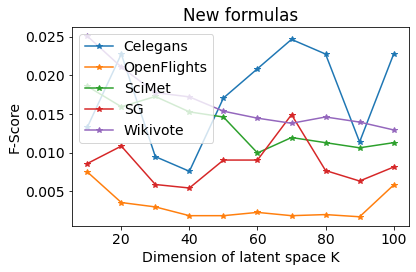

In [23]:
fig = plt.figure()
for network_name in AUC_values_old:
    plt.plot(np.arange(10, 110, 10), AUC_values_old[network_name], label=network_name, marker='*')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Dimension of latent space K')
plt.tight_layout()
plt.title('Original formulas')
plt.savefig('k_AUC_old.png')

fig = plt.figure()
for network_name in AUC_values_new:
    plt.plot(np.arange(10, 110, 10), AUC_values_new[network_name], label=network_name, marker='*')
plt.legend()
plt.ylabel('AUC')
plt.xlabel('Dimension of latent space K')
plt.tight_layout()
plt.title('New formulas')
plt.savefig('k_AUC_new.png')
    
fig = plt.figure()
for network_name in AUPR_values_old:
    plt.plot(np.arange(10, 110, 10), AUPR_values_old[network_name], label=network_name, marker='*')
plt.legend()
plt.ylabel('AUPR')
plt.xlabel('Dimension of latent space K')
plt.title('Original formulas')
plt.tight_layout()
plt.savefig('k_AUPR_old.png')

fig = plt.figure()
for network_name in AUPR_values_new:
    plt.plot(np.arange(10, 110, 10), AUPR_values_new[network_name], label=network_name, marker='*')
plt.legend()
plt.ylabel('AUPR')
plt.xlabel('Dimension of latent space K')
plt.title('New formulas')
plt.tight_layout()
plt.savefig('k_AUPR_new.png')


fig = plt.figure()
for network_name in Precision_values_old:
    plt.plot(np.arange(10, 110, 10), Precision_values_old[network_name], label=network_name, marker='*')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Dimension of latent space K')
plt.title('Original formulas')
plt.tight_layout()
plt.savefig('k_Precision_old.png')

fig = plt.figure()
for network_name in Precision_values_new:
    plt.plot(np.arange(10, 110, 10), Precision_values_new[network_name], label=network_name, marker='*')
plt.legend()
plt.ylabel('Precision')
plt.xlabel('Dimension of latent space K')
plt.title('New formulas')
plt.tight_layout()
plt.savefig('k_Precision_new.png')


fig = plt.figure()
for network_name in F_score_values_old:
    plt.plot(np.arange(10, 110, 10), F_score_values_old[network_name], label=network_name, marker='*')
plt.legend()
plt.ylabel('F-Score')
plt.xlabel('Dimension of latent space K')
plt.title('Original formulas')
plt.tight_layout()
plt.savefig('k_F_Score_old.png')

fig = plt.figure()
for network_name in F_score_values_new:
    plt.plot(np.arange(10, 110, 10), F_score_values_new[network_name], label=network_name, marker='*')
plt.legend()
plt.ylabel('F-Score')
plt.xlabel('Dimension of latent space K')
plt.title('New formulas')
plt.tight_layout()
plt.savefig('k_F_Score_new.png')